# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. 

With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. 

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

Compressed representation is useful for:
- capturing the essence structure of data (by removing correlations and redundancies)
- reconstruction of data
- transforming data

<img src='notebook_ims/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [2]:
num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

---
## Linear Autoencoder

A simple autoencoder can be created using **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='notebook_ims/simple_autoencoder.png' width=50% />

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

encoding_dim = 32  # Encoding dimension - number of neurons in the bottleneck layer.
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [4]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data  
        images = images.view(images.size(0), -1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, images)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

C:\Users\ashkan\Anaconda3\envs\py38torch\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.676990
Epoch: 2 	Training Loss: 0.373611
Epoch: 3 	Training Loss: 0.337618
Epoch: 4 	Training Loss: 0.329299
Epoch: 5 	Training Loss: 0.325865
Epoch: 6 	Training Loss: 0.323784
Epoch: 7 	Training Loss: 0.322333
Epoch: 8 	Training Loss: 0.321134
Epoch: 9 	Training Loss: 0.320046
Epoch: 10 	Training Loss: 0.319026
Epoch: 11 	Training Loss: 0.318072
Epoch: 12 	Training Loss: 0.317189
Epoch: 13 	Training Loss: 0.316365
Epoch: 14 	Training Loss: 0.315599
Epoch: 15 	Training Loss: 0.314894
Epoch: 16 	Training Loss: 0.314238
Epoch: 17 	Training Loss: 0.313632
Epoch: 18 	Training Loss: 0.313066
Epoch: 19 	Training Loss: 0.312535
Epoch: 20 	Training Loss: 0.312039


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

C:\Users\ashkan\Anaconda3\envs\py38torch\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


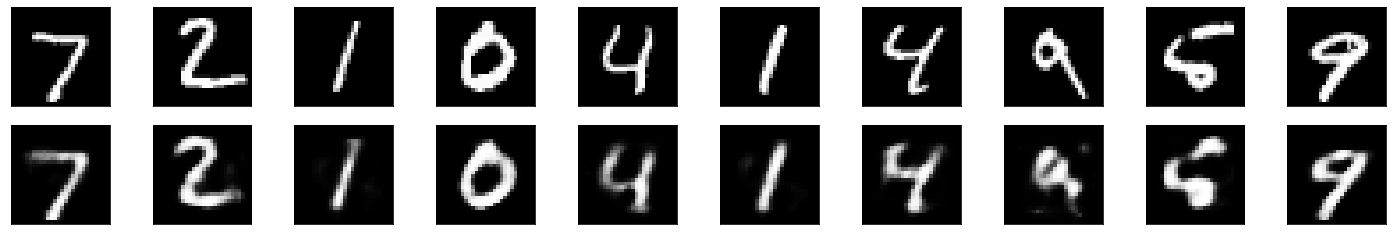

In [8]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)

with torch.no_grad():
    output = model(images_flatten)

images = images.numpy()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()  # No gradients are needed

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.